In [240]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt
%matplotlib inline

# Training Model and Evaluation

In [241]:
df = pd.read_csv("dataset/dataset_cleaned_train.csv")
df.describe()

,roll,pitch,yaw,acc_x,acc_y,acc_z,label
count,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000,282.000000
mean,2422.446809,-3109.042553,1244.858156,-294.365248,194.822695,512.138298,0.500000
std,18515.337665,26160.904944,9315.447746,328.075101,490.224740,515.951843,0.500889
min,-64610.000000,-88060.000000,-32970.000000,-1043.000000,-1059.000000,-425.000000,0.000000
25%,-1470.000000,-4637.500000,-1470.000000,-639.500000,-14.000000,-68.500000,0.000000
50%,770.000000,-770.000000,770.000000,-112.000000,-4.000000,821.000000,0.500000
75%,7735.000000,1820.000000,2940.000000,16.000000,727.250000,996.000000,1.000000
max,54110.000000,68950.000000,35420.000000,31.000000,1025.000000,1012.000000,1.000000


In [242]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.neural_network import MLPClassifier

In [243]:
X = df[[col for col in df.columns if col != "label"]]
y = df["label"]

In [244]:
fscore = []

###  Logistic Regression

In [245]:
LoRe = LogisticRegression(solver="lbfgs", random_state=42)
LoRe_score = cross_val_score(LoRe, X, y, cv=5, scoring='f1_micro')
fscore.append(LoRe_score.mean())
print(LoRe_score)

[1. 1. 1. 1. 1.]


###  Random Forest

In [246]:
randF = RandomForestClassifier(n_estimators=200)
randF_score = cross_val_score(randF, X, y, cv=5, scoring='f1_micro')
fscore.append(randF_score.mean())
print(randF_score)

[1. 1. 1. 1. 1.]


###  Gradient Boosting

In [247]:
gbc = GradientBoostingClassifier()
gbc_score = cross_val_score(gbc, X, y, cv=5, scoring='f1_micro')
fscore.append(gbc_score.mean())
print(gbc_score)

[1. 1. 1. 1. 1.]


###  Gaussian Naive Bayes

In [248]:
gnb = GaussianNB()
gnb_score = cross_val_score(gnb, X, y, cv=5, scoring='f1_micro')
fscore.append(gnb_score.mean())
print(gnb_score)

[1. 1. 1. 1. 1.]


###  Multi-layer Perceptron

In [249]:
mlp = MLPClassifier(activation='relu', max_iter=500)
mlp_score = cross_val_score(mlp, X, y, cv=5, scoring='f1_micro')
fscore.append(mlp_score.mean())
print(mlp_score)

[0.9137931  0.71428571 0.96428571 1.         0.98214286]


## F1 plot

[]

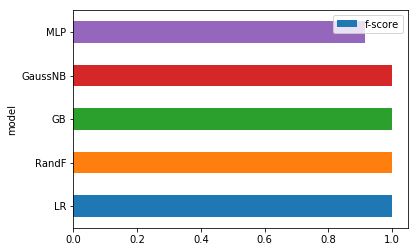

In [250]:
list_ = []
model_name = ["LR", "RandF", "GB", "GaussNB", "MLP"]
for i in range(len(model_name)):
    arr = {}
    arr["model"] = model_name[i]
    arr["f-score"] = fscore[i]
    list_.append(arr)
f1df = pd.DataFrame(list_)
f1df.plot.barh(x="model", y="f-score")
plt.plot()

In [339]:
import pickle

gbc = GradientBoostingClassifier()
gbc.fit(X, y)
pickle.dump(gbc, open("model/gbmodel.pkl", 'wb'))

---
## Prediction
### Try with cleaned data

In [319]:
import os

model = {}
target = "model/gbmodel.pkl"
if os.path.getsize(target) > 0:      
    with open(target, "rb") as f:
        unpickler = pickle.Unpickler(f)
        model = unpickler.load()

In [320]:
df_test = pd.read_csv("dataset/dataset_cleaned_test.csv")
X_test = df_test[[col for col in df_test.columns if col != "label"]]
y_test = df_test["label"]

In [321]:
from sklearn.metrics import classification_report
y_hat = model.predict(X_test)
print(classification_report(y_test,y_hat))

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        35
          1       1.00      1.00      1.00        35

avg / total       1.00      1.00      1.00        70



### Try with messy data

In [322]:
df_testm = pd.read_csv("dataset/dataset.csv")
X_testm = df_testm[[col for col in df_testm.columns if col != "label"]]
y_testm = df_testm["label"]

In [323]:
from sklearn.metrics import classification_report
y_hat = model.predict(X_testm)
print(classification_report(y_testm,y_hat))

             precision    recall  f1-score   support

          0       0.64      0.92      0.75       216
          1       0.96      0.78      0.86       528

avg / total       0.87      0.82      0.83       744



## Fine-tune Model

### ROC, AUC

In [ ]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_testm, y_hat)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

### Tune learning rate

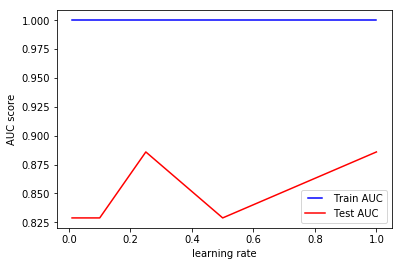

In [299]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
train_results = []
test_results = []
x_train, y_train = X, y
for eta in learning_rates:
    model = GradientBoostingClassifier(learning_rate=eta)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(X_testm)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_testm, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D

line1, = plt.plot(learning_rates, train_results, 'b', label="Train AUC")
line2, = plt.plot(learning_rates, test_results, 'r', label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("learning rate")
plt.show()

### Tune n-estimators

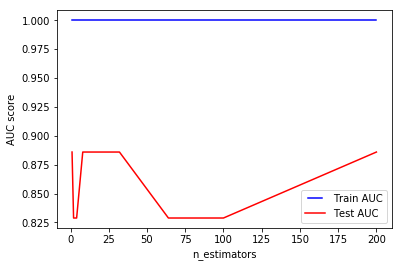

In [300]:
n_estimators = [1, 2, 4, 8, 16, 32, 64, 100, 200]
train_results = []
test_results = []
x_train, y_train = X, y
x_test, y_test = X_testm, y_testm
for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators=estimator)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, "b", label="Train AUC")
line2, = plt.plot(n_estimators, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("n_estimators")
plt.show()

### Tune max depths

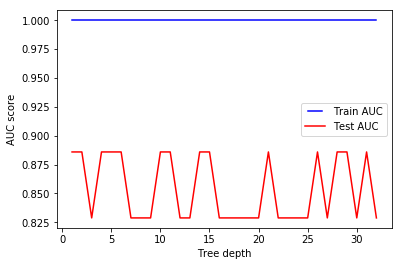

In [309]:
max_depths = np.linspace(1, 32, 32, endpoint=True)
train_results = []
test_results = []
x_train, y_train = X, y
x_test, y_test = X_testm, y_testm

for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth=max_depth)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_depths, train_results, "b", label="Train AUC")
line2, = plt.plot(max_depths, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("Tree depth")
plt.show()

### Tune min samples splits

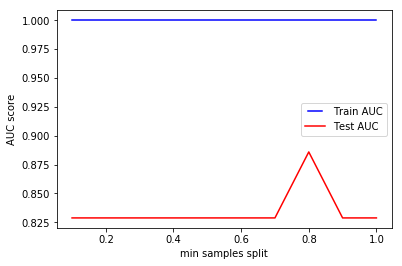

In [310]:
min_samples_splits = np.linspace(0.1, 1.0, 10, endpoint=True)
train_results = []
test_results = []
x_train, y_train = X, y
x_test, y_test = X_testm, y_testm

for min_samples_split in min_samples_splits:
    model = GradientBoostingClassifier(min_samples_split=min_samples_split)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_splits, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_splits, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min samples split")
plt.show()

### Tune min samples leafs

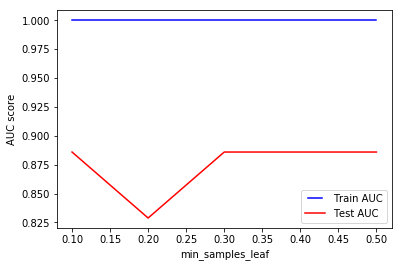

In [311]:
min_samples_leafs = np.linspace(0.1, 0.5, 5, endpoint=True)
train_results = []
test_results = []
x_train, y_train = X, y
x_test, y_test = X_testm, y_testm

for min_samples_leaf in min_samples_leafs:
    model = GradientBoostingClassifier(min_samples_leaf=min_samples_leaf)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)
    
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(min_samples_leafs, train_results, "b", label="Train AUC")
line2, = plt.plot(min_samples_leafs, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("min_samples_leaf")
plt.show()

### Tune max features

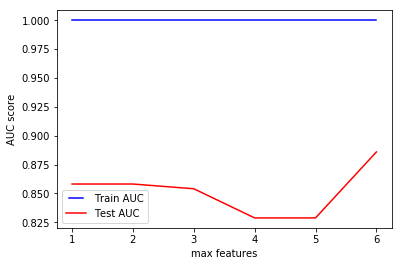

In [328]:
max_features = list(range(1, X.shape[1]+1))

train_results = []
test_results = []
x_train, y_train = X, y
x_test, y_test = X_testm, y_testm

for max_feature in max_features:
    model = GradientBoostingClassifier(max_features=max_feature)
    model.fit(x_train, y_train)
    train_pred = model.predict(x_train)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_train, train_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    train_results.append(roc_auc)
    y_pred = model.predict(x_test)
    false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    test_results.append(roc_auc)

from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(max_features, train_results, "b", label="Train AUC")
line2, = plt.plot(max_features, test_results, "r", label="Test AUC")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("AUC score")
plt.xlabel("max features")
plt.show()

## Export the model

In [342]:
import pickle
df_test = pd.read_csv("dataset/dataset_cleaned_test.csv")
X_test = df_test[[col for col in df_test.columns if col != "label"]]
y_test = df_test["label"]

gbc = GradientBoostingClassifier(learning_rate=0.25, n_estimators=16,
                                 max_depth=5, min_samples_split=0.8,
                                 min_samples_leaf=0.3, max_features=6)
gbc.fit(X, y)
y_hat = model.predict(X_testm)
print(classification_report(y_testm,y_hat))

y_hat = model.predict(X_test)
print(classification_report(y_test,y_hat))

pickle.dump(gbc, open("model/gbmodel.pkl", 'wb'))

             precision    recall  f1-score   support

          0       0.73      0.91      0.81       216
          1       0.96      0.86      0.91       528

avg / total       0.89      0.88      0.88       744

             precision    recall  f1-score   support

          0       1.00      1.00      1.00        35
          1       1.00      1.00      1.00        35

avg / total       1.00      1.00      1.00        70

